In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../Tetrahymena_Data/Tetrahymena_SJB_90', index_col='Unnamed: 0')

In [3]:
X = df.drop('Dependent', axis=1)
y = df['Dependent']

In [4]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [5]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)

## Default XGBoost Parameters

In [103]:
xgb = XGBRegressor(random_state=42)

Default Parameters 

KFold R2:  0.7779935303973468
KFold MAE:  0.353639986153266
KFold MSE:  0.2405886896661046
KFold RMSE:  0.49049840944299156


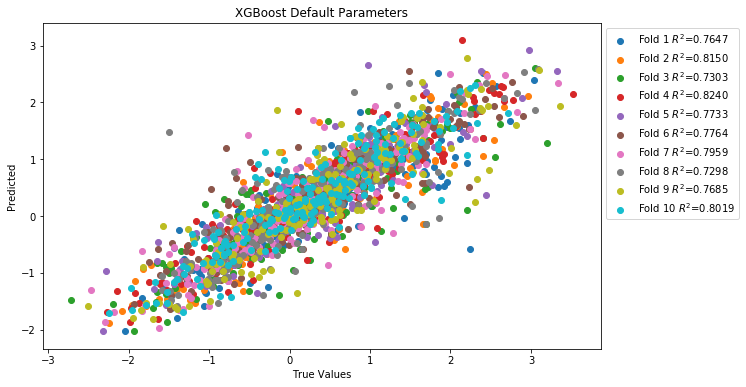

In [104]:
r2_model, mae_model, mse_model, train_r2_model = list(), list(), list(), list()

plt.figure(figsize=(10,6))
plt.title('XGBoost Default Parameters')
plt.ylabel('Predicted')
plt.xlabel('True Values')

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgb.fit(X_train, y_train)
    
    lab = 'Fold %d $R^2$=%.4f' % (i+1, r2_score(y_test, model.predict(X_test)))
    plt.scatter(y_test, model.predict(X_test), label=lab)
    
    r2_model.append(r2_score(y_test, model.predict(X_test)))
    mae_model.append(mean_absolute_error(y_test, model.predict(X_test)))
    mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    train_r2_model.append(r2_score(y_train, model.predict(X_train)))
    
r2_default = np.mean(r2_model)
mae_default = np.mean(mae_model)
mse_default = np.mean(mse_model)
rmse_default = np.sqrt(mse_default)
train_r2_default= np.mean(train_r2_model)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_Default_Parameters.png', bbox_inches='tight')

print('Default Parameters', '\n')
print('KFold R2: ', r2_default)
print('KFold MAE: ', mae_default)
print('KFold MSE: ', mse_default)
print('KFold RMSE: ', rmse_default)

In [102]:
print('R2 Train', train_r2_default)

R2 Train 0.9996059770104029


# Manual Parameter Tuning
## eta
### default=0.3, alias: learning_rate
Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

range: [0,1]

In [59]:
eta = np.linspace(0.005, 0.5, 30)
train_r2_eta, test_r2_eta, mse_eta = list(), list(), list()

for i in eta:
    
    xgb = XGBRegressor(eta=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_eta.append(np.mean(train_r2_model))
    test_r2_eta.append(np.mean(test_r2_model))
    mse_eta.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_eta))
print('eta: ', eta[test_r2_eta.index(max(test_r2_eta))])

Default R2:  0.7779935303973468
Optimal R2 0.7984033441859071
eta:  0.10741379310344829


In [143]:
print('Optimal R2 Train', train_r2_eta[test_r2_eta.index(max(test_r2_eta))])
print('MSE: ', mse_eta[test_r2_eta.index(max(test_r2_eta))])

Optimal R2 Train 0.991572839563618
MSE:  0.21861481769711913


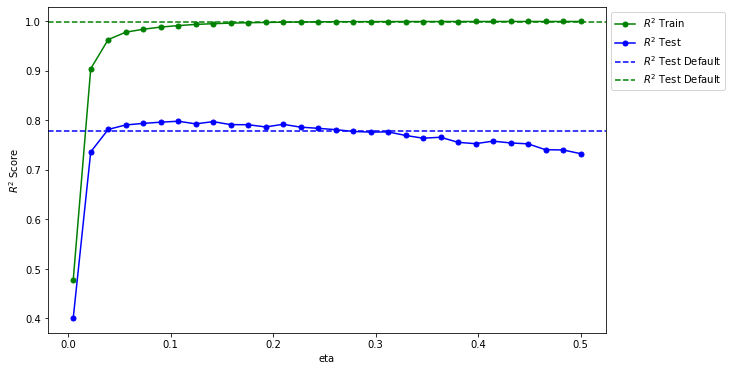

In [109]:
plt.figure(figsize=(10,6))
plt.plot(eta, train_r2_eta, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(eta, test_r2_eta, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('eta')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_eta_R2.png', bbox_inches='tight')

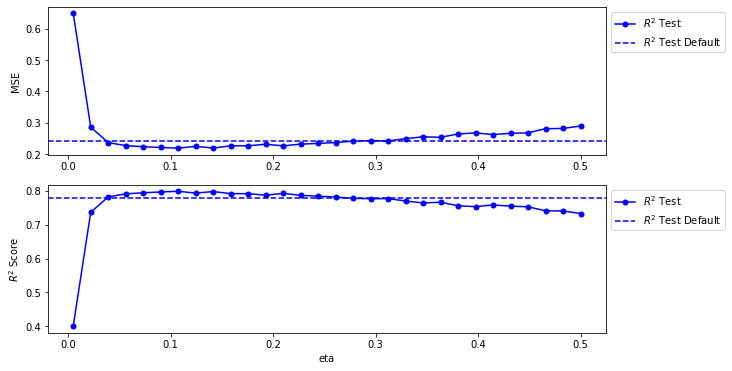

In [110]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(eta, test_r2_eta, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('eta')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(eta, mse_eta, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_eta_MSE_R2.png', bbox_inches='tight')

## min_child_weight
### default=1
Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.

range: [0,∞]

In [62]:
min_child_weight = list(range(1, 21))
train_r2_mcw, test_r2_mcw, mse_mcw = list(), list(), list()

for i in min_child_weight:
    
    xgb = XGBRegressor(min_child_weight=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_mcw.append(np.mean(train_r2_model))
    test_r2_mcw.append(np.mean(test_r2_model))
    mse_mcw.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_mcw))
print('min_child_weight: ', min_child_weight[test_r2_mcw.index(max(test_r2_mcw))])

Default R2:  0.7779935303973468
Optimal R2 0.7829809755287868
min_child_weight:  7


In [144]:
print('Optimal R2 Train', train_r2_mcw[test_r2_mcw.index(max(test_r2_mcw))])
print('MSE: ', mse_mcw[test_r2_mcw.index(max(test_r2_mcw))])

Optimal R2 Train 0.9993776271363595
MSE:  0.2351072105453317


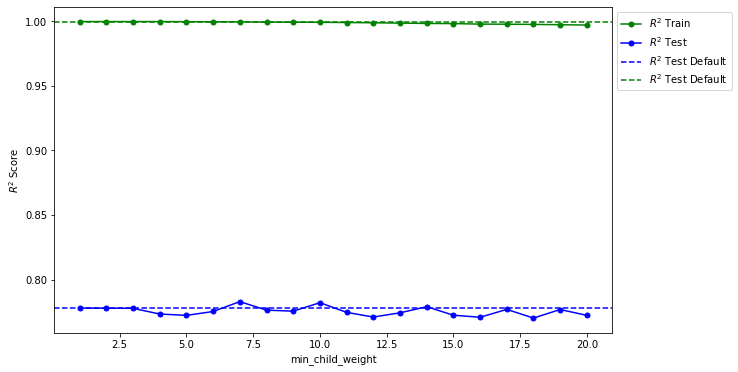

In [112]:
plt.figure(figsize=(10,6))
plt.plot(min_child_weight, train_r2_mcw, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(min_child_weight, test_r2_mcw, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('min_child_weight')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_min_child_weight_R2.png', bbox_inches='tight')

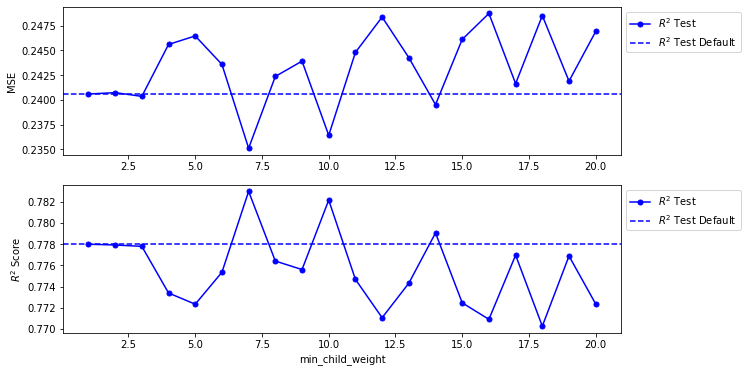

In [113]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(min_child_weight, test_r2_mcw, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('min_child_weight')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(min_child_weight, mse_mcw, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_min_child_weight_MSE_R2.png', bbox_inches='tight')

## max_depth
### default=6
Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 is only accepted in lossguided growing policy when tree_method is set as hist or gpu_hist and it indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree.

range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist or gpu_hist)

In [66]:
max_depth = list(range(1, 51))
train_r2_md, test_r2_md, mse_md = list(), list(), list()

for i in max_depth:
    
    xgb = XGBRegressor(max_depth=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_md.append(np.mean(train_r2_model))
    test_r2_md.append(np.mean(test_r2_model))
    mse_md.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_md))
print('max_depth: ', max_depth[test_r2_md.index(max(test_r2_md))])

Default R2:  0.7779935303973468
Optimal R2 0.7798435956080061
max_depth:  4


In [145]:
print('Optimal R2 Train', train_r2_md[test_r2_md.index(max(test_r2_md))])
print('MSE: ', mse_md[test_r2_md.index(max(test_r2_md))])

Optimal R2 Train 0.989520805992961
MSE:  0.23827702880689508


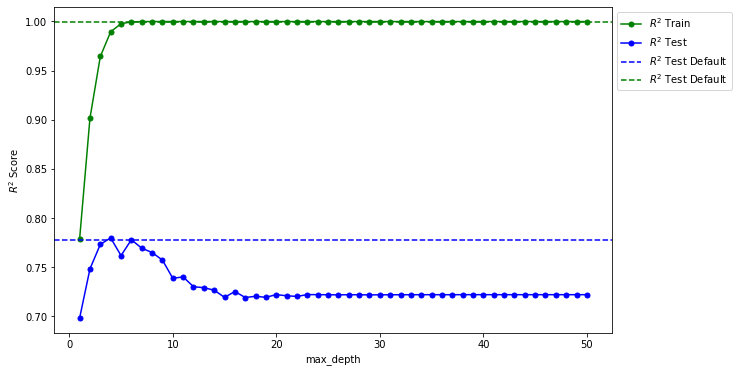

In [115]:
plt.figure(figsize=(10,6))
plt.plot(max_depth, train_r2_md, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(max_depth, test_r2_md, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('max_depth')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_max_depth_R2.png', bbox_inches='tight')

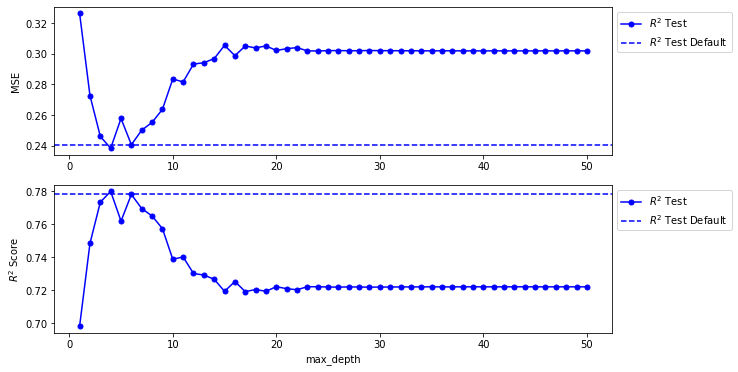

In [116]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(max_depth, test_r2_md, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(max_depth, mse_md, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_max_depth_MSE_R2.png', bbox_inches='tight')

## gamma
### default=0, alias: min_split_loss
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

range: [0,∞]

In [69]:
gamma = np.linspace(0, 3, 30)
train_r2_g, test_r2_g, mse_g = list(), list(), list()

for i in gamma:
    
    xgb = XGBRegressor(gamma=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_g.append(np.mean(train_r2_model))
    test_r2_g.append(np.mean(test_r2_model))
    mse_g.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_g))
print('gamma: ', gamma[test_r2_g.index(max(test_r2_g))])

Default R2:  0.7779935303973468
Optimal R2 0.7803108371411283
gamma:  0.10344827586206896


In [146]:
print('Optimal R2 Train', train_r2_g[test_r2_g.index(max(test_r2_g))])
print('MSE: ', mse_g[test_r2_g.index(max(test_r2_g))])

Optimal R2 Train 0.9897139109230302
MSE:  0.23820730680200244


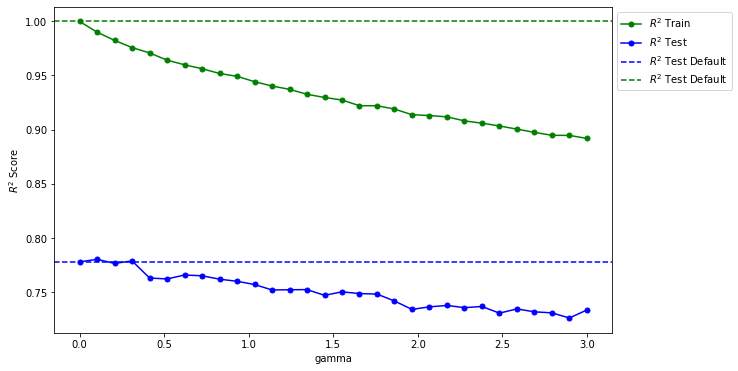

In [118]:
plt.figure(figsize=(10,6))
plt.plot(gamma, train_r2_g, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(gamma, test_r2_g, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('gamma')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_gamma_R2.png', bbox_inches='tight')

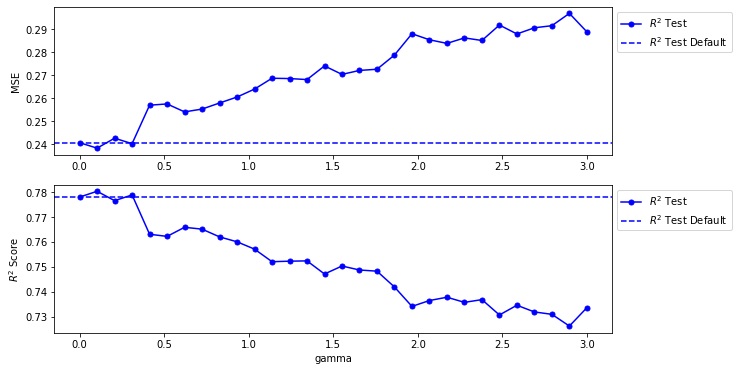

In [119]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(gamma, test_r2_g, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('gamma')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(gamma, mse_g, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_gamma_MSE_R2.png', bbox_inches='tight')

## n_estimators
### default=100
n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably.

In [35]:
n_estimators = list(range(50, 510, 10))
train_r2_ne, test_r2_ne, mse_ne = list(), list(), list()

for i in n_estimators:
    
    xgb = XGBRegressor(n_estimators=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_ne.append(np.mean(train_r2_model))
    test_r2_ne.append(np.mean(test_r2_model))
    mse_ne.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_ne))
print('n_estimators: ', n_estimators[test_r2_ne.index(max(test_r2_ne))])

Default R2:  0.7779935303973468
Optimal R2 0.7787350276474443
n_estimators:  250


In [147]:
print('Optimal R2 Train', train_r2_ne[test_r2_ne.index(max(test_r2_ne))])
print('MSE: ', mse_ne[test_r2_ne.index(max(test_r2_ne))])

Optimal R2 Train 0.9999202116354269
MSE:  0.23977672096186162


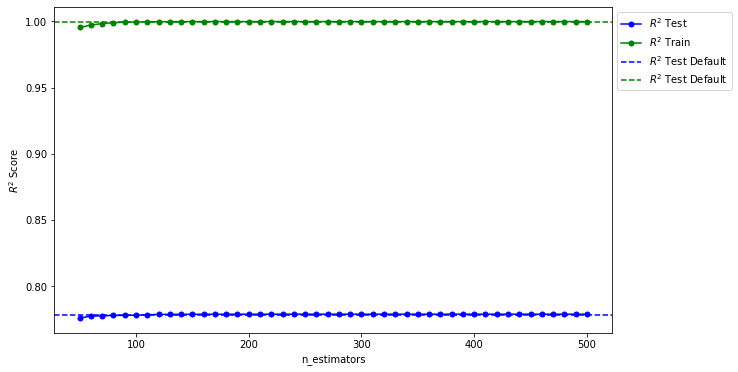

In [123]:
plt.figure(figsize=(10,6))
plt.plot(n_estimators, test_r2_ne, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.plot(n_estimators, train_r2_ne, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('n_estimators')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_n_estimators_R2.png', bbox_inches='tight')

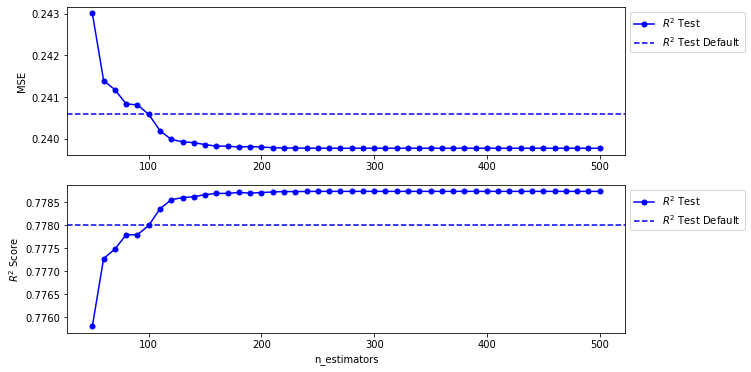

In [122]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(n_estimators, test_r2_ne, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(n_estimators, mse_ne, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_n_estimators_MSE_R2.png', bbox_inches='tight')

## subsample
### default=1

Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

In [50]:
subsample = np.linspace(0.1, 1, 10)
train_r2_ss, test_r2_ss, mse_ss = list(), list(), list()

for i in subsample:
    
    xgb = XGBRegressor(subsample=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_ss.append(np.mean(train_r2_model))
    test_r2_ss.append(np.mean(test_r2_model))
    mse_ss.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_ss))
print('subsample: ', subsample[test_r2_ss.index(max(test_r2_ss))])

Default R2:  0.7779935303973468
Optimal R2 0.7779935303973468
subsample:  1.0


In [148]:
print('Optimal R2 Train', train_r2_ss[test_r2_ss.index(max(test_r2_ss))])
print('MSE: ', mse_ss[test_r2_ss.index(max(test_r2_ss))])

Optimal R2 Train 0.9996059770104029
MSE:  0.2405886896661046


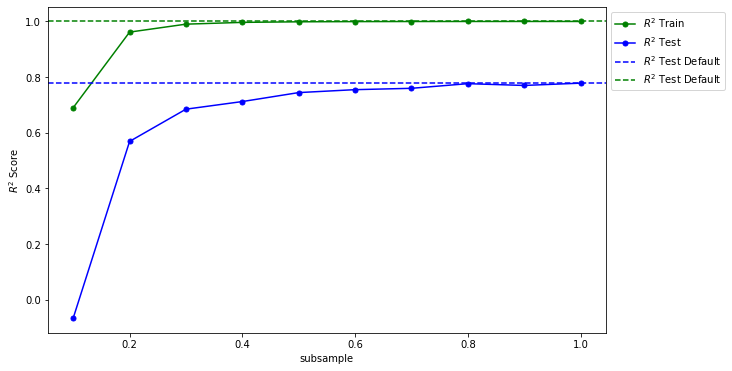

In [125]:
plt.figure(figsize=(10,6))
plt.plot(subsample, train_r2_ss, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(subsample, test_r2_ss, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('subsample')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_subsample_R2.png', bbox_inches='tight')

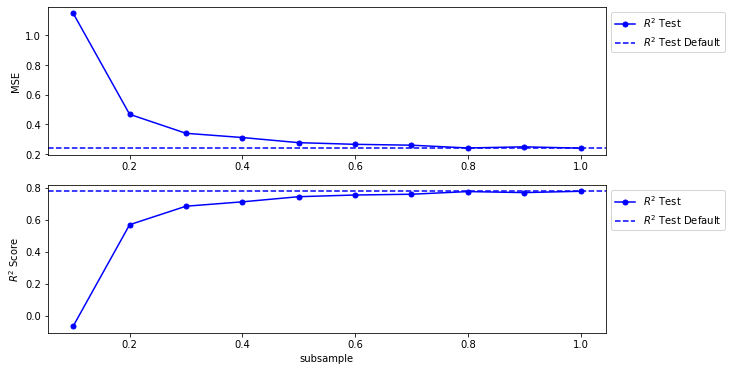

In [126]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(subsample, test_r2_ss, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('subsample')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(subsample, mse_ss, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_subsample_MSE_R2.png', bbox_inches='tight')

## colsample_bytree
### default=1

This is a family of parameters for subsampling of columns.

All colsample_by* parameters have a range of (0, 1], the default value of 1, and specify the fraction of columns to be subsampled.

colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

colsample_bylevel is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.

colsample_bynode is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.

colsample_by* parameters work cumulatively. For instance, the combination {'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5} with 64 features will leave 8 features to choose from at each split.

On Python interface, when using hist, gpu_hist or exact tree method, one can set the feature_weights for DMatrix to define the probability of each feature being selected when using column sampling. There’s a similar parameter for fit method in sklearn interface.

In [53]:
colsample_bytree = np.linspace(0.1, 1, 10)
train_r2_csbt, test_r2_csbt, mse_csbt = list(), list(), list()

for i in colsample_bytree:
    
    xgb = XGBRegressor(colsample_bytree=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_csbt.append(np.mean(train_r2_model))
    test_r2_csbt.append(np.mean(test_r2_model))
    mse_csbt.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_csbt))
print('colsample_bytree: ', colsample_bytree[test_r2_csbt.index(max(test_r2_csbt))])

Default R2:  0.7779935303973468
Optimal R2 0.7798964488310446
colsample_bytree:  0.6


In [149]:
print('Optimal R2 Train', train_r2_csbt[test_r2_csbt.index(max(test_r2_csbt))])
print('MSE: ', mse_csbt[test_r2_csbt.index(max(test_r2_csbt))])

Optimal R2 Train 0.999525974121962
MSE:  0.23872205904679905


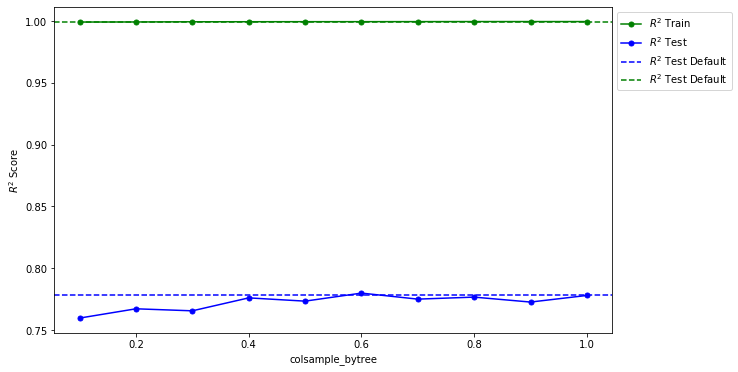

In [128]:
plt.figure(figsize=(10,6))
plt.plot(colsample_bytree, train_r2_csbt, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(colsample_bytree, test_r2_csbt, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('colsample_bytree')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_colsample_bytree_R2.png', bbox_inches='tight')

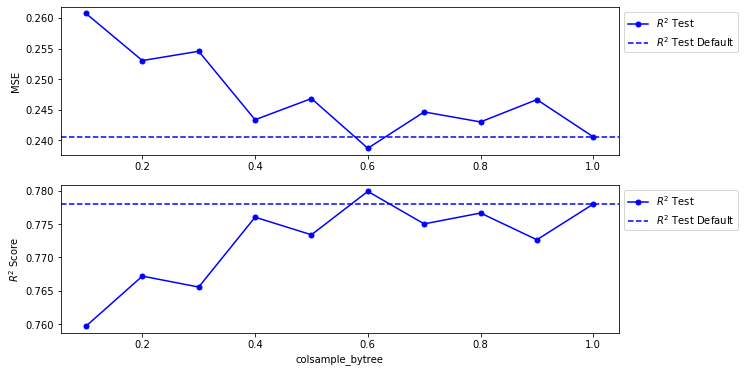

In [129]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(colsample_bytree, test_r2_csbt, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('colsample_bytree')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(colsample_bytree, mse_csbt, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_colsample_bytree_MSE_R2.png', bbox_inches='tight')

## max_delta_step
### default=0

Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update.

In [81]:
max_delta_step = list(range(0,11))
train_r2_mds, test_r2_mds, mse_mds = list(), list(), list()

for i in max_delta_step:
    
    xgb = XGBRegressor(max_delta_step=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_mds.append(np.mean(train_r2_model))
    test_r2_mds.append(np.mean(test_r2_model))
    mse_mds.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_mds))
print('max_delta_step: ', max_delta_step[test_r2_mds.index(max(test_r2_mds))])

Default R2:  0.7779935303973468
Optimal R2 0.7779935303973468
max_delta_step:  0


In [150]:
print('Optimal R2 Train', train_r2_mds[test_r2_mds.index(max(test_r2_mds))])
print('MSE: ', mse_mds[test_r2_mds.index(max(test_r2_mds))])

Optimal R2 Train 0.9996059770104029
MSE:  0.2405886896661046


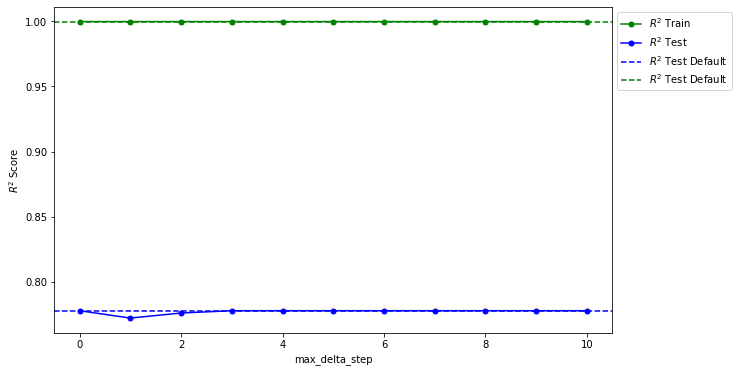

In [131]:
plt.figure(figsize=(10,6))
plt.plot(max_delta_step, train_r2_mds, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(max_delta_step, test_r2_mds, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('max_delta_step')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_max_delta_step_R2.png', bbox_inches='tight')

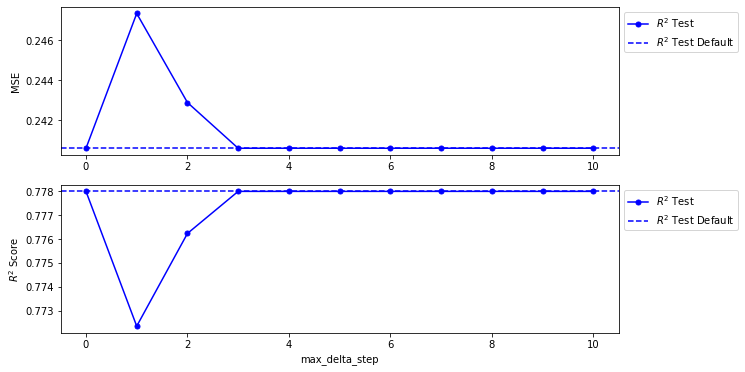

In [132]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(max_delta_step, test_r2_mds, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('max_delta_step')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(max_delta_step, mse_mds, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_max_delta_step_MSE_R2.png', bbox_inches='tight')

## lambda
### default=1, alias: reg_lambda

L2 regularization term on weights. Increasing this value will make model more conservative.

In [84]:
reg_lambda = np.linspace(0, 1, 10)
train_r2_rl, test_r2_rl, mse_rl = list(), list(), list()

for i in reg_lambda:
    
    xgb = XGBRegressor(reg_lambda=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_rl.append(np.mean(train_r2_model))
    test_r2_rl.append(np.mean(test_r2_model))
    mse_rl.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_rl))
print('reg_lambda: ', reg_lambda[test_r2_rl.index(max(test_r2_rl))])

Default R2:  0.7779935303973468
Optimal R2 0.7782442470844707
reg_lambda:  0.7777777777777777


In [151]:
print('Optimal R2 Train', train_r2_rl[test_r2_rl.index(max(test_r2_rl))])
print('MSE: ', mse_rl[test_r2_rl.index(max(test_r2_rl))])

Optimal R2 Train 0.9995789677489691
MSE:  0.2405466597089206


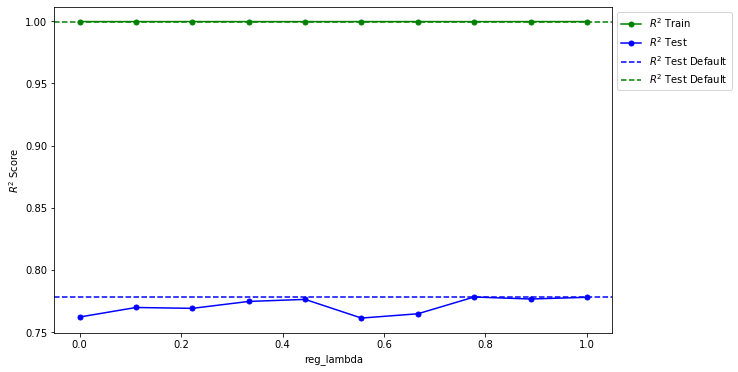

In [134]:
plt.figure(figsize=(10,6))
plt.plot(reg_lambda, train_r2_rl, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(reg_lambda, test_r2_rl, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('reg_lambda')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_reg_lambda_R2.png', bbox_inches='tight')

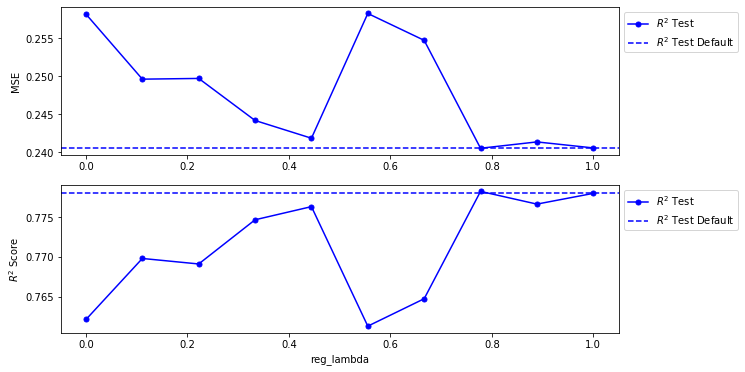

In [135]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(reg_lambda, test_r2_rl, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('reg_lambda')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(reg_lambda, mse_rl, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_reg_lambda_MSE_R2.png', bbox_inches='tight')

## alpha
### default=0, alias: reg_alpha

L1 regularization term on weights. Increasing this value will make model more conservative.

In [87]:
reg_alpha = list(range(0,11))
train_r2_ra, test_r2_ra, mse_ra = list(), list(), list()

for i in reg_alpha:
    
    xgb = XGBRegressor(reg_alpha=i, random_state=42)
    train_r2_model, test_r2_model, mse_model = list(), list(), list()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = xgb.fit(X_train, y_train)
    
        train_r2_model.append(r2_score(y_train, model.predict(X_train)))
        test_r2_model.append(r2_score(y_test, model.predict(X_test)))
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    train_r2_ra.append(np.mean(train_r2_model))
    test_r2_ra.append(np.mean(test_r2_model))
    mse_ra.append(np.mean(mse_model))
    

print('Default R2: ', r2_default)
print('Optimal R2', max(test_r2_ra))
print('reg_alpha: ', reg_alpha[test_r2_ra.index(max(test_r2_ra))])

Default R2:  0.7779935303973468
Optimal R2 0.7835389630236671
reg_alpha:  3


In [152]:
print('Optimal R2 Train', train_r2_ra[test_r2_ra.index(max(test_r2_ra))])
print('MSE: ', mse_ra[test_r2_ra.index(max(test_r2_ra))])

Optimal R2 Train 0.9915634578129733
MSE:  0.2345992096774249


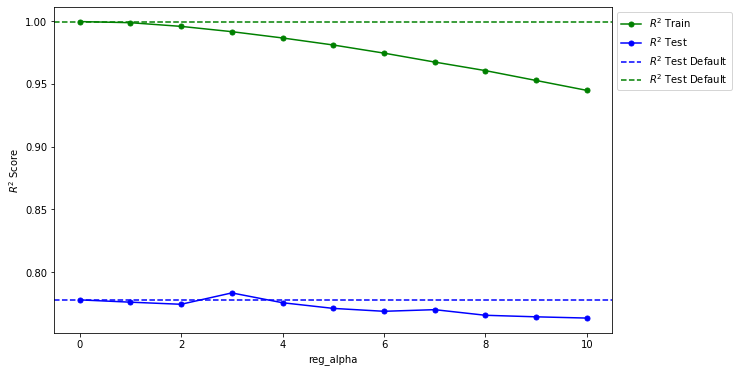

In [137]:
plt.figure(figsize=(10,6))
plt.plot(reg_alpha, train_r2_ra, color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5,label='$R^2$ Train')
plt.plot(reg_alpha, test_r2_ra, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Test Default')
plt.xlabel('reg_alpha')
plt.ylabel('$R^2$ Score')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_reg_alpha_R2.png', bbox_inches='tight')

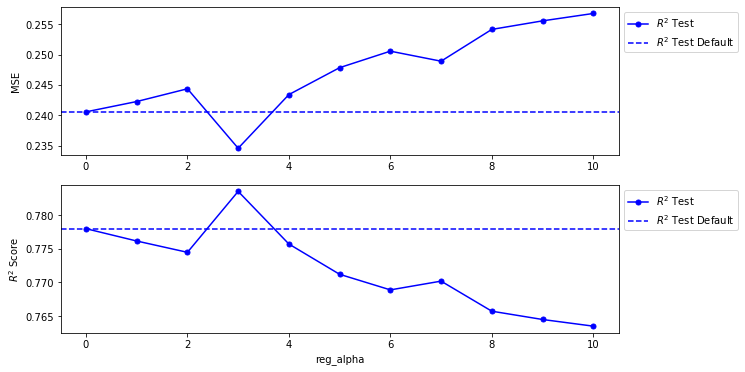

In [138]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
ax2.plot(reg_alpha, test_r2_ra, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax2.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax2.set_xlabel('reg_alpha')
ax2.set_ylabel('$R^2$ Score')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.plot(reg_alpha, mse_ra, color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
ax1.axhline(mse_default, linestyle='--', color='b', label='$R^2$ Test Default')
ax1.set_ylabel('MSE')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_reg_alpha_MSE_R2.png', bbox_inches='tight')

## Manual Optimal Parameters

Manual Parameters 

KFold R2 Test:  0.8001148670826461
KFold R2 Train:  0.9744584435241759
KFold MAE:  0.33527793178562243
KFold MSE:  0.21646898720925023
KFold RMSE:  0.46526227787050417


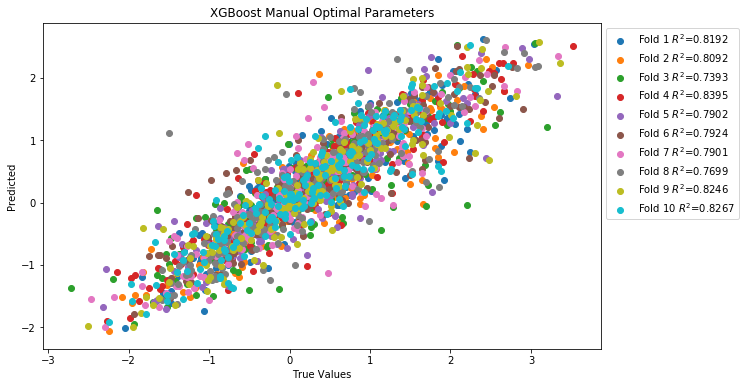

In [139]:
xgb_mopt = XGBRegressor(eta=0.10741379310344829,
                       min_child_weight=7, 
                       max_depth=4, 
                       gamma=0.10344827586206896, 
                       n_estimators=250, 
                       colsample_bytree=0.6,
                       reg_lambda=0.7777777777777777, 
                       reg_alpha=3, 
                       random_state=42)

r2_mopt, mae_mopt, mse_mopt, train_r2_mopt = list(), list(), list(), list()

plt.figure(figsize=(10,6))
plt.title('XGBoost Manual Optimal Parameters')
plt.ylabel('Predicted')
plt.xlabel('True Values')

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgb_mopt.fit(X_train, y_train)
    
    lab = 'Fold %d $R^2$=%.4f' % (i+1, r2_score(y_test, model.predict(X_test)))
    plt.scatter(y_test, model.predict(X_test), label=lab)
    
    r2_mopt.append(r2_score(y_test, model.predict(X_test)))
    mae_mopt.append(mean_absolute_error(y_test, model.predict(X_test)))
    mse_mopt.append(mean_squared_error(y_test, model.predict(X_test)))
    train_r2_mopt.append(r2_score(y_train, model.predict(X_train)))
    
r2_manual = np.mean(r2_mopt)
mae_manual = np.mean(mae_mopt)
mse_manual = np.mean(mse_mopt)
rmse_manual = np.sqrt(mse_manual)
train_r2_manual = np.mean(train_r2_mopt)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_Manual_Parameters.png', bbox_inches='tight')

print('Manual Parameters', '\n')
print('KFold R2 Test: ', r2_manual)
print('KFold R2 Train: ', train_r2_manual)
print('KFold MAE: ', mae_manual)
print('KFold MSE: ', mse_manual)
print('KFold RMSE: ', rmse_manual)

# GridSearch Parameter Tuning

In [91]:
from sklearn.model_selection import RandomizedSearchCV

In [92]:
eta = np.linspace(0.1, 0.15, 6)
gamma = np.linspace(0, 0.3, 4)
max_depth = list(range(2, 9))
min_child_weight = list(range(1, 11))
subsample = np.linspace(0.8, 1, 3)
colsample_bytree = np.linspace(0.5, 1, 6)
n_estimators = list(range(100, 260, 10))

param_grid = {'eta': eta,
             'gamma': gamma,
             'max_depth': max_depth,
             'min_child_weight': min_child_weight,
             'subsample': subsample,
             'colsample_bytree': colsample_bytree,
             'n_estimators': n_estimators}

In [93]:
cv = KFold(n_splits=10, shuffle=True, random_state=101)
xgb_gs = XGBRegressor(random_state=42)

random_grid = RandomizedSearchCV(estimator=xgb_gs, 
                                 param_distributions=param_grid, 
                                 cv=cv, 
                                 n_iter=50,
                                 scoring='r2',
                                 verbose=3,
                                 return_train_score=True,
                                 random_state=42)

In [94]:
random_grid.fit(X, y)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6, score=(train=0.986, test=0.823), total=   1.6s
[CV] subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6, score=(train=0.988, test=0.812), total=   1.5s
[CV] subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6, score=(train=0.987, test=0.733), total=   1.4s
[CV] subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6 
[CV]  subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6, score=(train=0.986, test=0.838), total=   1.5s
[CV] subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6 
[CV]  subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6, score=(train=0.987, test=0.810), total=   1.6s
[CV] subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6 
[CV]  subsample=1.0, n_estimators=220, min_child_weight=1, max_depth=4, gamma=0.0, eta=0.13, colsample_bytree=0.6, score=(train=0.988, test=0.770), total=   1.4s
[CV] subsa

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 16.0min finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=101, shuffle=True),
                   error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weigh...
                                        'eta': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15]),
                                        'gamma': array([0. , 0.1, 0.2, 0.3]),
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
          

In [95]:
random_grid.best_params_

{'subsample': 0.8,
 'n_estimators': 250,
 'min_child_weight': 4,
 'max_depth': 4,
 'gamma': 0.09999999999999999,
 'eta': 0.1,
 'colsample_bytree': 0.9}

GridSearch Parameters 

KFold Test R2:  0.8081984531978452
KFold Train R2:  0.9860445547361516
KFold MAE:  0.3263604339844467
KFold MSE:  0.2077207094576811
KFold RMSE:  0.45576387467380636


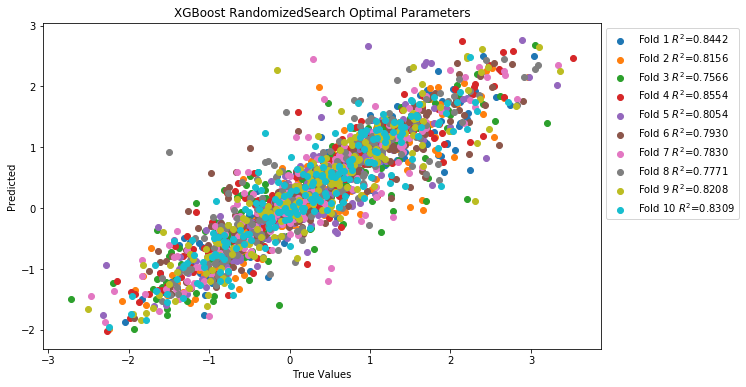

In [167]:
xgb_gsopt = random_grid.best_estimator_

r2_gsopt, mae_gsopt, mse_gsopt, train_r2_gsopt = list(), list(), list(), list()

plt.figure(figsize=(10,6))
plt.title('XGBoost RandomizedSearch Optimal Parameters')
plt.ylabel('Predicted')
plt.xlabel('True Values')

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgb_gsopt.fit(X_train, y_train)
    
    lab = 'Fold %d $R^2$=%.4f' % (i+1, r2_score(y_test, model.predict(X_test)))
    plt.scatter(y_test, model.predict(X_test), label=lab)
    
    r2_gsopt.append(r2_score(y_test, model.predict(X_test)))
    mae_gsopt.append(mean_absolute_error(y_test, model.predict(X_test)))
    mse_gsopt.append(mean_squared_error(y_test, model.predict(X_test)))
    train_r2_gsopt.append(r2_score(y_train, model.predict(X_train)))
    
r2_grid = np.mean(r2_gsopt)
mae_grid = np.mean(mae_gsopt)
mse_grid = np.mean(mse_gsopt)
rmse_grid = np.sqrt(mse_grid)
train_r2_grid = np.mean(train_r2_gsopt)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_Random_Parameters.png', bbox_inches='tight')

print('GridSearch Parameters', '\n')
print('KFold Test R2: ', r2_grid)
print('KFold Train R2: ', train_r2_grid)
print('KFold MAE: ', mae_grid)
print('KFold MSE: ', mse_grid)
print('KFold RMSE: ', rmse_grid)

In [97]:
gs_cv = pd.DataFrame(random_grid.cv_results_)

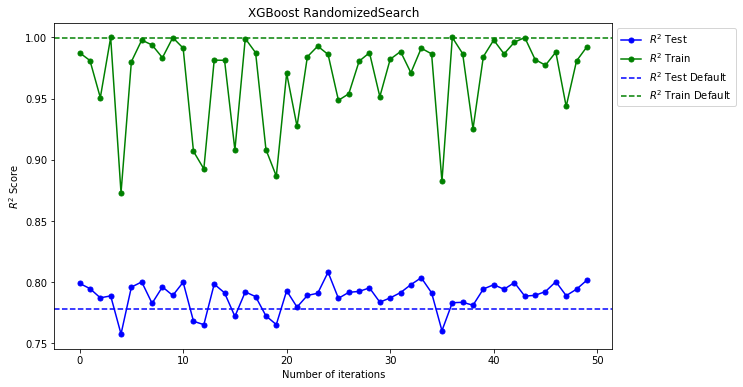

In [141]:
plt.figure(figsize=(10,6))
plt.plot(gs_cv['mean_test_score'], color='b', linestyle='-', marker='o', markerfacecolor='b', markersize=5, label='$R^2$ Test')
plt.plot(gs_cv['mean_train_score'], color='g', linestyle='-', marker='o', markerfacecolor='g', markersize=5, label='$R^2$ Train')
plt.axhline(r2_default, linestyle='--', color='b', label='$R^2$ Test Default')
plt.axhline(train_r2_default, linestyle='--', color='g', label='$R^2$ Train Default')
plt.ylabel('$R^2$ Score')
plt.xlabel('Number of iterations')
plt.title('XGBoost RandomizedSearch')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_RandomizedSearchCV.png', bbox_inches='tight')

# Optuna Parameter Tuning

In [153]:
import optuna

In [156]:
def objective(trial):
    
    xgb_eta = trial.suggest_loguniform('eta', 0.1, 0.15, )
    xgb_gamma = trial.suggest_uniform('gamma', 0, 0.3)
    xgb_md = trial.suggest_int('max_depth', 2, 9)
    xgb_mcw = trial.suggest_int('min_child_weight', 1, 11)
    xgb_ss = trial.suggest_uniform('subsample', 0.8, 1)
    xgb_csbt = trial.suggest_uniform('colsample_bytree', 0.5, 1)
    xgb_ne = trial.suggest_int('n_estimators', 100, 250)
    xgb = XGBRegressor(eta=xgb_eta, 
                       gamma=xgb_gamma,
                       max_depth=xgb_md,
                       min_child_weight=xgb_mcw,
                       subsample=xgb_ss,
                       colsample_bytree=xgb_csbt,
                       n_estimators=xgb_ne,
                       random_state=42)

    mse_model = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = xgb.fit(X_train, y_train)
        
        mse_model.append(mean_squared_error(y_test, model.predict(X_test)))
    
    return np.mean(mse_model)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2021-06-15 17:05:12,753] A new study created in memory with name: no-name-a421651b-54f2-424a-85f1-d47672e8245a
[I 2021-06-15 17:05:48,945] Trial 0 finished with value: 0.23338857670280908 and parameters: {'eta': 0.1303830667340884, 'gamma': 0.2829799932280646, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.964113974365489, 'colsample_bytree': 0.6359667258454132, 'n_estimators': 249}. Best is trial 0 with value: 0.23338857670280908.
[I 2021-06-15 17:05:54,343] Trial 1 finished with value: 0.27720415557368777 and parameters: {'eta': 0.14691220834244656, 'gamma': 0.07965198136749516, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.9476276328314615, 'colsample_bytree': 0.7828552166599559, 'n_estimators': 108}. Best is trial 0 with value: 0.23338857670280908.
[I 2021-06-15 17:06:02,876] Trial 2 finished with value: 0.22903297677243253 and parameters: {'eta': 0.11284814033417265, 'gamma': 0.09790951704344299, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.91776652579

'eta': 0.10348358061349136, 'gamma': 0.0014522585882654332, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8161555109586542, 'colsample_bytree': 0.9615776257412139, 'n_estimators': 205

In [157]:
xgb_optuna = XGBRegressor(eta=0.10348358061349136, 
                          gamma=0.0014522585882654332, 
                          max_depth=5, 
                          min_child_weight=2, 
                          subsample=0.8161555109586542, 
                          colsample_bytree=0.9615776257412139, 
                          n_estimators=205,
                          random_state=42)

Optuna Parameters 

KFold R2:  0.8109220031617997
KFold Train R2:  0.9950865516255037
KFold MAE:  0.32411805141852734
KFold MSE:  0.20506099552139595
KFold RMSE:  0.4528366101822996


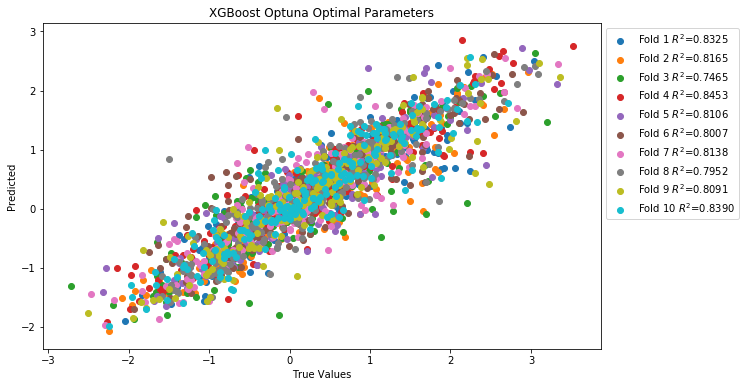

In [166]:
r2_opt, mae_opt, mse_opt, train_r2_opt = list(), list(), list(), list()

plt.figure(figsize=(10,6))
plt.title('XGBoost Optuna Optimal Parameters')
plt.ylabel('Predicted')
plt.xlabel('True Values')

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgb_optuna.fit(X_train, y_train)
    
    lab = 'Fold %d $R^2$=%.4f' % (i+1, r2_score(y_test, model.predict(X_test)))
    plt.scatter(y_test, model.predict(X_test), label=lab)
    
    r2_opt.append(r2_score(y_test, model.predict(X_test)))
    mae_opt.append(mean_absolute_error(y_test, model.predict(X_test)))
    mse_opt.append(mean_squared_error(y_test, model.predict(X_test)))
    train_r2_opt.append(r2_score(y_train, model.predict(X_train)))
    
r2_optuna = np.mean(r2_opt)
mae_optuna = np.mean(mae_opt)
mse_optuna = np.mean(mse_opt)
rmse_optuna = np.sqrt(mse_optuna)
train_r2_optuna = np.mean(train_r2_opt)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Graphs/XGBoost_Optuna.png', bbox_inches='tight')

print('Optuna Parameters', '\n')
print('KFold R2: ', r2_optuna)
print('KFold Train R2: ', train_r2_optuna)
print('KFold MAE: ', mae_optuna)
print('KFold MSE: ', mse_optuna)
print('KFold RMSE: ', rmse_optuna)

In [161]:
optuna.visualization.plot_contour(study)

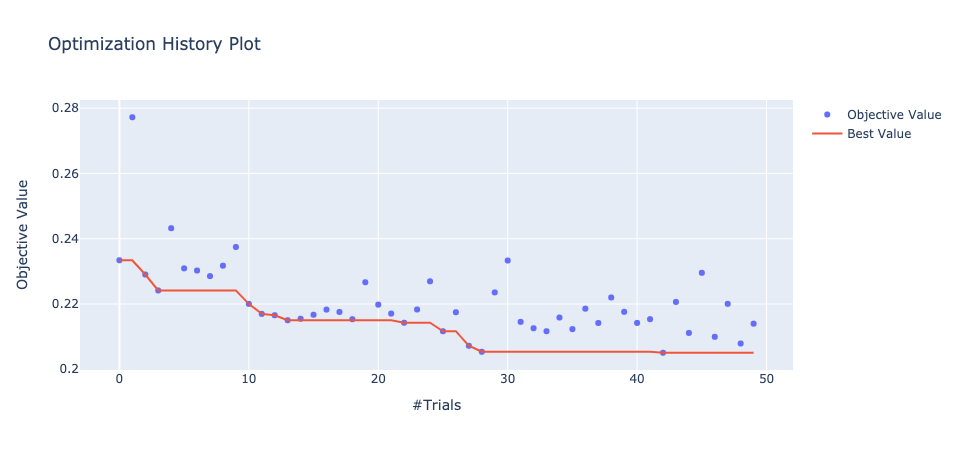

In [162]:
optuna.visualization.plot_optimization_history(study)

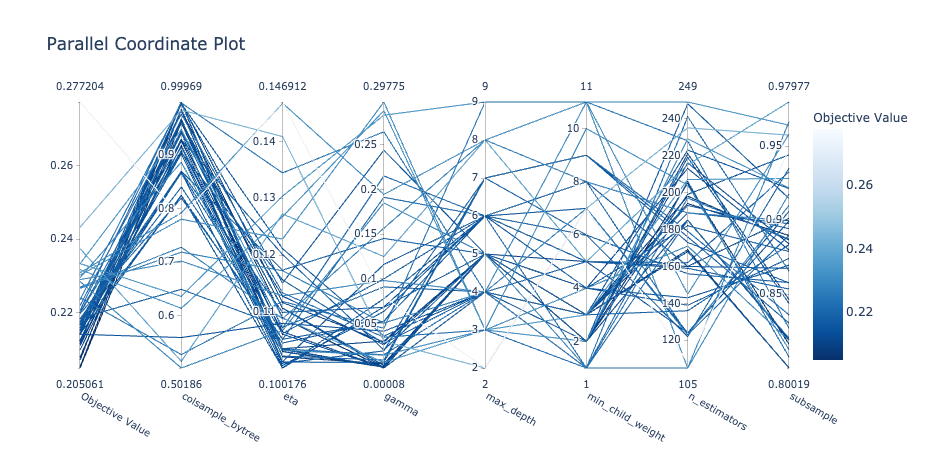

In [163]:
optuna.visualization.plot_parallel_coordinate(study)

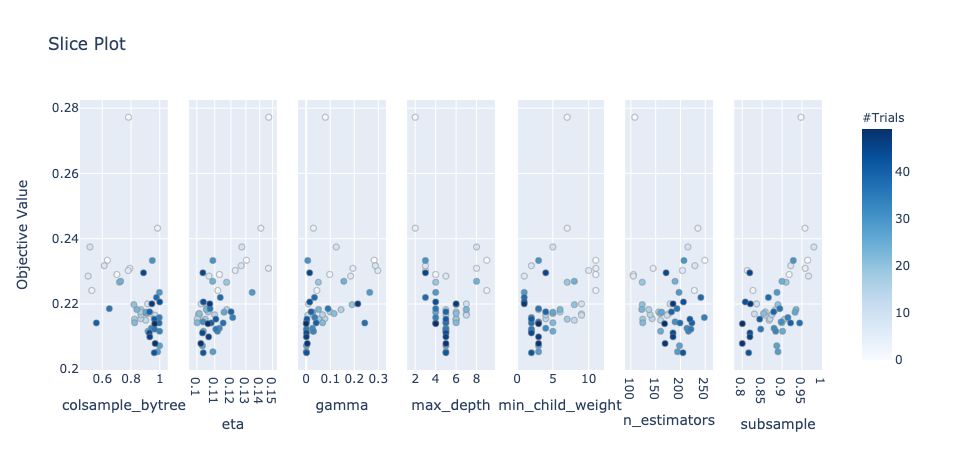

In [164]:
optuna.visualization.plot_slice(study)

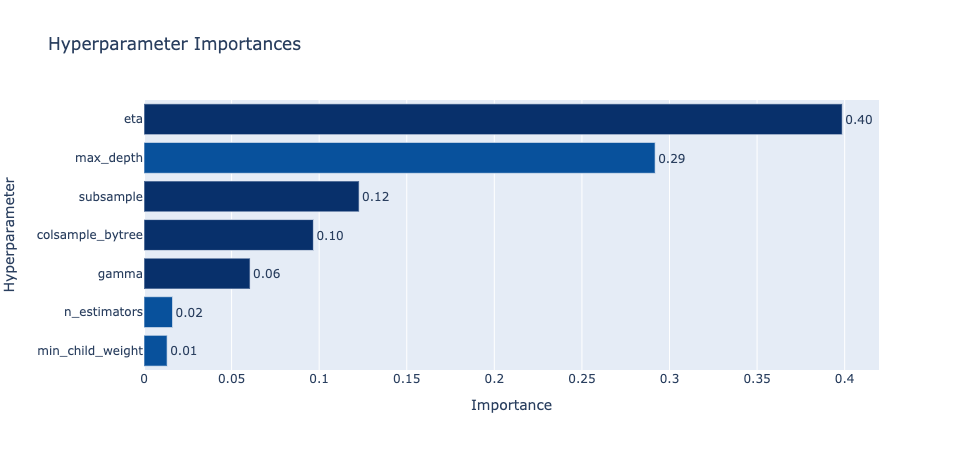

In [165]:
optuna.visualization.plot_param_importances(study)